# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis
import yfinance as yf

from Stock_Data import get_close

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

# Importing Data

In [5]:
#start_date=datetime.datetime(2020,1,1)
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [6]:
days=(today-start_date).days
days

1911

In [7]:
remaining=days%500
numbers_of_table=days//500

In [8]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:30].to_list()

In [9]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(tickers,temp_end)
omusdt=Binance.get_price(['OMUSDT'],temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]
prices['OMUSDT']=omusdt

In [10]:
gold=get_close(['SPY','GOLD.PA','BTC-USD'],start=start_date.strftime("%Y-%m-%d"),end=today.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [11]:
prices['GOLD.PA']=gold['GOLD.PA']

In [12]:
correlation_btc=pct_change['GOLD.PA'].rolling(30).corr(pct_change['BTC-USD']).dropna()
correlation_spy=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()

#beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['BTC-USD']).dropna()/pct_change['BTC-USD'].rolling(30).var().dropna())

In [13]:
info=pd.DataFrame()
info['Correlation SPY']=correlation_spy
info['Correlation BTC']=correlation_btc

In [14]:
info.iloc[-30:]

,Correlation SPY,Correlation BTC
2025-02-10,-0.115584,0.002907
2025-02-11,-0.108379,0.035769
2025-02-12,-0.124539,-0.036242
2025-02-13,-0.173182,-0.047368
2025-02-14,-0.151595,-0.065559
2025-02-18,-0.108859,-0.288822
2025-02-19,-0.041075,-0.267661
2025-02-20,-0.001237,-0.199809
2025-02-21,0.056457,-0.163271
2025-02-24,0.062427,-0.086834


<Axes: >

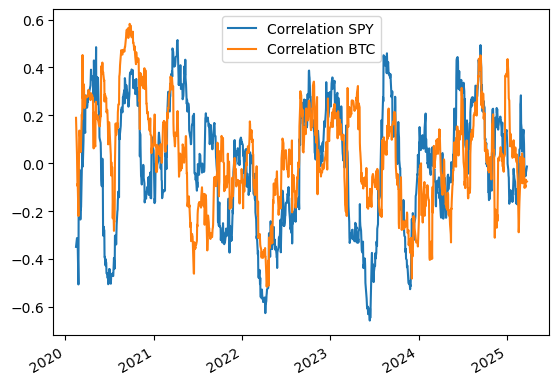

In [15]:
info.plot()

In [16]:
returns=np.log(1+prices.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()


C:\Users\Admin\AppData\Local\Temp\ipykernel_12744\3925264644.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns=np.log(1+prices.pct_change())


In [17]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [18]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [20]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [21]:
returns_to_use

,ADAUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,LINKUSDT,LTCUSDT,TRXUSDT,USDCUSDT,XLMUSDT,XRPUSDT,GOLD.PA
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.018997,-0.000391,0.000168,0.000781,0.005448,0.012388,0.010685,0.024481,0.007718,-0.006033,-0.000100,0.007535,0.000518,NaN
2020-01-02,-0.023879,-0.044765,-0.052981,-0.033200,-0.014629,-0.027758,-0.033402,-0.042005,-0.054054,-0.029166,-0.000798,-0.037800,-0.029170,NaN
2020-01-03,0.044279,0.129103,0.047792,0.053015,0.014184,0.054766,0.033402,0.038077,0.068604,0.045670,-0.001597,0.045936,0.030878,0.014455
2020-01-04,0.004963,0.009130,0.011786,0.001245,0.016808,-0.001117,0.070859,0.011135,0.012940,0.000000,-0.000300,-0.000219,-0.001708,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-22,-0.005119,-0.002478,-0.012930,-0.002956,0.000598,0.007571,-0.010620,0.019845,0.005817,0.014878,-0.000200,-0.010889,-0.004125,0.000000
2025-03-23,0.013172,0.009262,-0.005149,0.026389,0.030770,0.012692,0.017746,0.015321,0.001203,-0.029981,-0.000200,0.032672,0.028357,0.000000
2025-03-24,0.029530,0.021585,0.021081,0.016312,0.058509,0.036807,0.037997,0.044602,0.024725,-0.007857,-0.000100,0.026492,0.004418,-0.000009
2025-03-25,0.017335,0.010471,-0.011461,-0.001204,0.040796,-0.007258,0.008149,0.020282,0.006272,-0.004392,-0.000100,0.010607,-0.000367,0.000000


In [22]:
results={}
btc_limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0]
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

In [23]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                        {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T

C:\Users\Admin\Desktop\Jupyter\Projets\Risk Management\RiskMetrics.py:266: RuntimeWarning: invalid value encountered in sqrt
  variance=np.sqrt(np.dot(weights.T,np.dot(self.returns.cov(),weights)))*np.sqrt(252)


In [24]:
correlation_threshold=0
gold_limit=0.2
rolling_optimization_adjusted=rolling_optimization.copy()

In [25]:
correlation=pd.DataFrame(index=dates_end)
correlation['Correlation']=correlation_btc
correlation=correlation.ffill().bfill()

In [26]:
for date in dates_end[:]:
    
    if correlation.loc[date].item()<correlation_threshold:
        
        temp=rolling_optimization_adjusted.loc[date]
        sum_numerator=temp.loc[temp.index!='GOLD.PA'].sum()-gold_limit
    
        normalized_weights=temp.loc[temp.index!='GOLD.PA']*sum_numerator
        normalized_weights['GOLD.PA']=0.2
        rolling_optimization_adjusted.loc[date]=normalized_weights
    else:
        
        continue

In [27]:
tracking={}
portfolio={}
investment_amount=1
initial_amount=investment_amount
perf=dataframe.pct_change()
transaction_fee=0.005
gold_limit=0.05
weight_dict={col: 1/returns_to_use.shape[1] for col in returns_to_use.columns}


for i in range(len(dates_end)-1):
    
    print(dates_end[i],investment_amount,investment_amount/initial_amount)

    
    temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
    initial_price=temp.iloc[0].to_dict()

    if dates_end[i]>dates_end[0]:

        top50=rolling_optimization.loc[dates_end[i]]
        top50_dict=rolling_optimization.loc[dates_end[i]].to_dict()
        weight_dict={}

        for key in temp.columns:

            if key in top50_dict: 
                weight_dict[key]=top50_dict[key]
            else:
                weight_dict[key]=0

                
    weight_vec=np.array(list(weight_dict.values()))
    
    inital_investment_per_stock={}
    shares={}

    for col in temp.columns:
        
        weighted_perf=weight_vec*perf.loc[dates_end[i]]
        
        inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
        shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

    tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

    temp=temp*shares    
    portfolio[dates_end[i]]=temp
    investment_amount=temp.iloc[-1].sum()
    

temp=dataframe.loc[dates_end[-2]:]*shares
portfolio[dates_end[-1]]=temp

2020-01-01 00:00:00 1 1.0
2020-01-31 00:00:00 1.2921644607969993 1.2921644607969993
2020-02-28 00:00:00 1.7740058890466865 1.7740058890466865
2020-03-31 00:00:00 1.2824468101545288 1.2824468101545288
2020-04-30 00:00:00 1.7289035605393097 1.7289035605393097
2020-05-29 00:00:00 1.766180236498696 1.766180236498696
2020-06-30 00:00:00 1.6433276487190138 1.6433276487190138
2020-07-31 00:00:00 2.284351474529943 2.284351474529943
2020-08-31 00:00:00 2.477754803394623 2.477754803394623
2020-09-30 00:00:00 2.457220720067268 2.457220720067268
2020-10-30 00:00:00 2.776864025072149 2.776864025072149
2020-11-30 00:00:00 3.727230113558971 3.727230113558971
2020-12-31 00:00:00 4.798971370866452 4.798971370866452
2021-01-29 00:00:00 7.568383338401249 7.568383338401249
2021-02-26 00:00:00 31.35169778868202 31.35169778868202
2021-03-31 00:00:00 41.55872911267718 41.55872911267718
2021-04-30 00:00:00 92.65997796004739 92.65997796004739
2021-05-31 00:00:00 70.05960932833344 70.05960932833344
2021-06-30 0

C:\Users\Admin\AppData\Local\Temp\ipykernel_12744\2300152772.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


In [28]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])

In [29]:
historical_portfolio.sum(axis=1)

2020-01-01      0.929400
2020-01-02      0.899694
2020-01-03      0.942643
2020-01-04      0.952615
2020-01-05      0.958617
                 ...    
2025-03-22    400.871853
2025-03-23    407.825540
2025-03-24    413.524887
2025-03-25    412.552719
2025-03-26    408.973330
Length: 1912, dtype: float64

<Axes: >

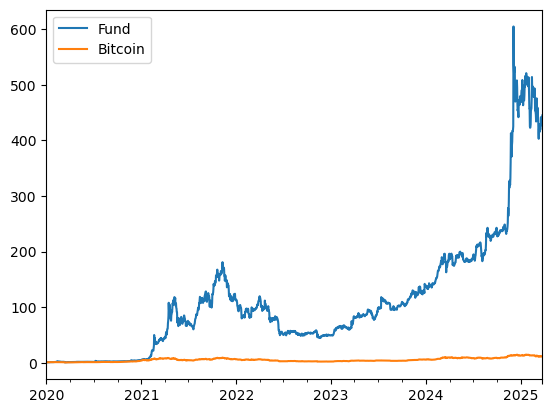

In [30]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [31]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

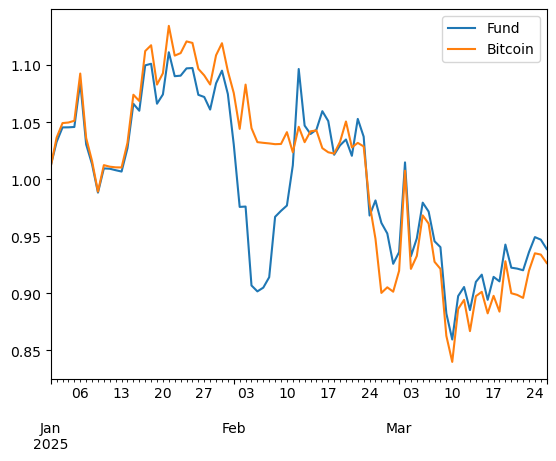

In [32]:
(1+performance_pct.loc['2025']).cumprod().plot()

In [33]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [34]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,4.163516,20.522722,-0.561066,1.773495,2.390898,-0.063942
Bitcoin,3.016697,0.575665,-0.653364,1.544636,1.118084,-0.076105


In [35]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [36]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03
Fund,0.390321,0.297207,-0.248649,0.305888,0.009362,-0.110516,0.389475,0.014037,-0.027340,0.143948,...,0.039781,0.073677,0.156467,0.050870,0.079682,0.721859,0.118409,0.062154,-0.101392,0.011613
Bitcoin,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,0.298694,...,-0.073706,0.027472,-0.097623,0.105158,0.156009,0.387245,-0.037137,0.082859,-0.161828,0.015434


In [37]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']

In [38]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.577999
Fund Vol,0.745677
Bench Vol,0.536150
Fund Return,443.891500
Bench Return,12.136466
Sharpe Ratio,3.204580


In [39]:
last_weights=tracking[dates_end[-2]][0]
weights=pd.DataFrame(last_weights.values(),index=last_weights.keys(),columns=['Weights Model'])

current_positions=Binance.get_inventory().round(4)
current_positions.columns=['Current Portfolio in USDT','Current Weights']
amount=current_positions.loc['Total']['Current Portfolio in USDT']

last_prices=Binance.get_price(list(last_weights.keys()))

quantities={}

for key in last_weights:
    quantities[key]=amount*last_weights[key]#/last_prices[key].values[0]

positions=pd.DataFrame(quantities.values(),index=quantities.keys(),columns=['Mark To Market Model'])
positions=pd.concat([positions,weights],axis=1)

condition=current_positions.index!='Total'
portfolio=pd.concat([positions,current_positions.loc[condition]],axis=1).fillna(0)
portfolio.loc['Total']=portfolio.sum(axis=0)
portfolio.sort_values(by='Weights Model',ascending=False).round(4)

GOLD.PA not retrieved


,Mark To Market Model,Weights Model,Current Portfolio in USDT,Current Weights
Total,4455.1908,1.0000,4455.1909,0.9999
TRXUSDT,2437.6131,0.5471,111.9306,0.0251
BNBUSDT,1111.9889,0.2496,1.0505,0.0002
BTCUSDT,886.3558,0.1989,767.3627,0.1722
BCHUSDT,19.2331,0.0043,0.0000,0.0000
XRPUSDT,0.0000,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
BBUSDT,0.0000,0.0000,17.4851,0.0039
JASMYUSDT,0.0000,0.0000,160.2951,0.0360
SOLUSDT,0.0000,0.0000,244.5387,0.0549
